In [380]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re

In [381]:
pd.set_option('display.max_rows', 300)

In [382]:
# Read all JSON files, transpose (swap columns and rows) and merge them into on dataframe
df_1 = pd.read_json(r'/home/tobia/Repos/randomstats/gsmarena/phones_dict.json').T
df_2 = pd.read_json(r'/home/tobia/Repos/randomstats/gsmarena/phones_dict_2.json').T
df_3 = pd.read_json(r'/home/tobia/Repos/randomstats/gsmarena/phones_dict_3.json').T
df = pd.concat([df_1, df_2, df_3])

In [383]:
# Drop unsuccessfully scraped columns and replace garbage values with np.nan
df = df.drop(columns=['null', 'net2g', 'net3g', 'net4g', 'net5g', 'gprstext', 'edge', 'speed'])
df = df.fillna(value=np.nan)
df = df.replace('-', np.nan)

In [384]:
# Apply, but for multiple values returned by function
def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((dataframe, dataframe[field].apply(lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

# usage example: apply_and_concat(df, 'displayresolution', get_display_res, ['res_a', 'res_b'])

In [385]:
# Get the year in which phone was announced
def get_announced_year(input):
    input = str(input)
    if 'exp' in input.lower():
        return np.nan
    if re.search('[0-9]{4}', input) is not None:
        if 'Released' in input:
            return int(re.search('[0-9]{4}', input.split('Released')[0]).group())
        else:
            return int(re.search('[0-9]{4}', input).group())
    return np.nan

In [386]:
# Get the month (as number) in which phone was announced
def get_announced_month(input):
    input = str(input)
    if 'exp' in input.lower():
        return np.nan
    for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']:
        if 'Released' in input:
            if month in input.split('Released')[0]:
                return datetime.datetime.strptime(month, "%B").month
        else:
            if month in input:
                return datetime.datetime.strptime(month, "%B").month
    return np.nan

In [387]:
# Get the quarter (as number) in which phone was announced
def get_announced_quarter(input):
    input = str(input)
    if re.search('Q[1-4]', input.split('Released')[0]):
        return int(re.search('Q[1-4]', input.split('Released')[0]).group().replace('Q', ''))
    return np.nan

In [388]:
# Get weight in grams as float
def parse_weight(input):
    input = str(input)
    if 'g' in input and re.search('[0-9]+', input) is not None:
        return float(re.search('[0-9]+', input.split('g')[0]).group())
    return np.nan

In [389]:
# Get the display resolution as a list of two numbers
def get_screen_res(input):
    res_a = np.nan
    res_b = np.nan
    input = str(input)
    if re.search('[0-9]+ x [0-9]+ pixels', input):
        res_txt = re.search('[0-9]+ x [0-9]+ pixels', input).group()
        res_a = int(res_txt.split('pixels')[0].split('x')[0])
        res_b = int(res_txt.split('pixels')[0].split('x')[1])
    return  res_a, res_b

In [390]:
# Get the display size (diagonal in inches)
def get_screen_size(input):
    input = str(input)
    if re.search('[0-9]+.[0-9]+ inches', input):
        size_txt = re.search('[0-9]+.[0-9]+ inches', input).group()
        return float(size_txt.split('inches')[0])
    return np.nan


In [391]:
# Get RAM info in MB
def get_ram(input):
    input = str(input)
    if re.search('[0-9]+[M|G]B RAM', input):
        ram_txt = re.search('[0-9]+[M|G]B RAM', input).group()
        ram_num = int(re.search('\d+', ram_txt).group())
        if 'GB' in ram_txt:
            return ram_num*1024
        elif 'MB' in ram_txt:
            return ram_num
    return np.nan

In [392]:
# Get memory in MB
def get_memory(input):
    input = str(input)
    if re.search('[0-9]+[M|G]B RAM', input):
        ram_txt = re.search('[0-9]+[M|G]B RAM', input).group()
        mem_txt = input.replace(ram_txt, '')
        if re.search('\d+', mem_txt):
            mem_num = int(re.search('\d+', mem_txt).group())
            if 'GB' in mem_txt:
                return mem_num*1024
            elif 'MB' in mem_txt:
                return mem_num
    else:
        if re.search('\d+', input):
            mem_num = int(re.search('\d+', input).group())
            if 'GB' in input:
                return mem_num*1024
            elif 'MB' in input:
                return mem_num
    return np.nan

In [393]:
# Get version of Android as a float
def get_android_ver(input):
    input = str(input)
    if re.search('Android [0-9]+.[0-9]*', input):
        ver_txt = re.search('Android [0-9]+[.0-9]{0,2}', input).group()
        return float(ver_txt.replace('Android', ''))
    return np.nan

In [394]:
# Number of main cameras
def get_cam_num(input):
    input = str(input)
    return input.count('MP')    

In [395]:
# Battery capacity in mAh
def get_batt_cap(input):
    input = str(input)
    if re.search('[0-9]+ mAh', input):
        batt_txt = re.search('[0-9]+ mAh', input).group()
        return int(re.search('\d+', batt_txt).group())
    return np.nan

In [396]:
# Price the initial in EUR
def get_price(input):
    input = str(input)
    if re.search('[0-9]+ EUR', input):
        price_txt = re.search('[0-9]+ EUR', input).group()
        return int(re.search('\d+', price_txt).group())
    elif re.search('€ [0-9]+', input):
        price_txt = re.search('€ [0-9]+', input).group()
        return int(re.search('\d+', price_txt).group())

In [397]:
# Remove tablets
fltr_tablets = df.loc[:, 'displaysize'].apply(get_screen_size) < 7
df_phones = df.loc[fltr_tablets, :]

In [398]:
# Remove smartphones more expensive then 1.5kEUR
fltr_1_5k = df.loc[:, 'price'].apply(get_price) < 1500
df_phones = df_phones.loc[fltr_1_5k, :]

In [399]:
# Add column with date
df_phones.loc[:, 'day'] = 15
df_phones.loc[:, 'month'] = df_phones.loc[:, 'year'].apply(get_announced_month)
df_phones.loc[:, 'year'] = df_phones.loc[:, 'year'].apply(get_announced_year)
df_phones_dates = df_phones.loc[:, ['year', 'month', 'day']]
df_phones.loc[:, 'date'] = pd.to_datetime(df_phones_dates)


In [400]:
# Remove phones from before 2007 (too few models)
fltr_2007 = df.loc[:, 'year'].apply(get_announced_year) > 2006
df_phones = df_phones.loc[fltr_2007, :]

In [401]:
# Year plus quarter (as part of 10) concatenated (will be easier to make diagram)
def get_year_quarter_concat(input):
    if isinstance(input, pd._libs.tslibs.timestamps.Timestamp):
        if input.quarter == 1:
            return float(f"{int(str(input.year))}0")
        elif input.quarter == 2:
            return float(f"{int(str(input.year))}2.5")
        elif input.quarter == 3:
            return float(f"{int(str(input.year))}5")
        elif input.quarter == 4:
            return float(f"{int(str(input.year))}7.5")
    else:
        return np.nan

In [402]:
# Add column with the year and quarter as one number
df_phones.loc[:, 'year_quarter'] = df_phones.loc[:, 'date'].apply(get_year_quarter_concat)

In [403]:
# Group phones by quarters they were produced
quarter_group = df_phones.groupby(df_phones.loc[:, 'year_quarter'])

<BarContainer object of 59 artists>

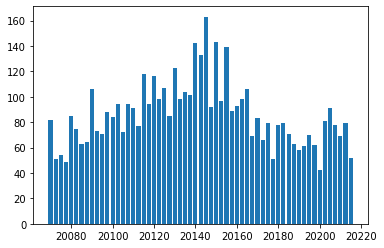

In [404]:
# Show how many phones were released each quarter
time = quarter_group.model.count().index
num_of_models = quarter_group.model.count().values
plt.bar(x=time, height=num_of_models, width=2)

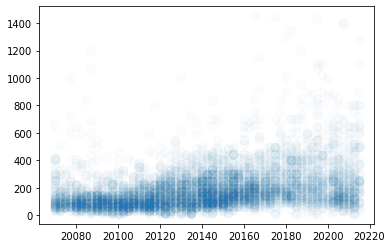

In [405]:
# Show the price of the phones per quarter
time = df_phones.loc[:, 'year_quarter']
price = df_phones.loc[:, 'price'].apply(get_price)
plt.scatter(time, price, s=80, alpha=0.02)

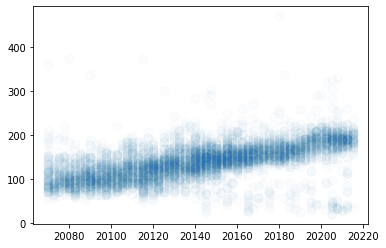

In [406]:
# Show how weight changed
time = df_phones.loc[:, 'year_quarter']
weight = df_phones.loc[:, 'weight'].apply(parse_weight)
plt.scatter(time, weight, s=80, alpha=0.02)

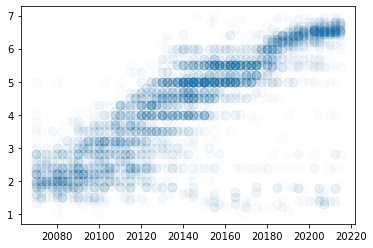

In [407]:
# Show how screen size changed
time = df_phones.loc[:, 'year_quarter']
display = df_phones.loc[:, 'displaysize'].apply(get_screen_size)
plt.scatter(time, display, s=80, alpha=0.02)

In [408]:
# Add column with internal memory in MB
df_phones.loc[:, 'memory_in_mb'] = df_phones.loc[:, 'internalmemory'].apply(get_memory)

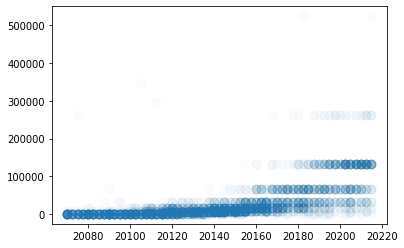

In [409]:
# Show how internal memory size changed
time = df_phones.loc[:, 'year_quarter']
memory = df_phones.loc[:, 'internalmemory'].apply(get_memory)
plt.scatter(time, memory, s=80, alpha=0.02)

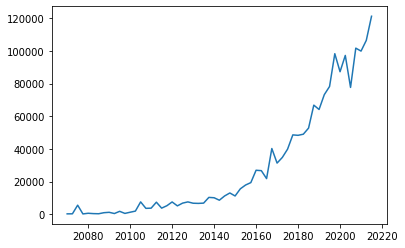

In [410]:
# Show mean memory size
time = quarter_group['memory_in_mb'].mean().index
memory_mean = quarter_group['memory_in_mb'].mean().values
plt.plot(time, memory_mean)

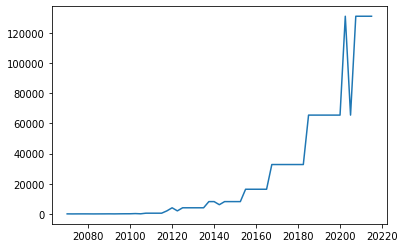

In [411]:
# Show median memory size
time = quarter_group['memory_in_mb'].median().index
memory_median = quarter_group['memory_in_mb'].median().values
plt.plot(time, memory_median)

In [412]:
df.columns

Index(['manufacturer', 'model', 'year', 'status', 'dimensions', 'weight',
       'sim', 'bodyother', 'displaytype', 'displaysize', 'displayresolution',
       'os', 'chipset', 'cpu', 'memoryslot', 'internalmemory', 'cam1modules',
       'cam1video', 'cam2modules', 'cam2video', 'wlan', 'bluetooth', 'gps',
       'nfc', 'radio', 'usb', 'sensors', 'batdescription1', 'battalktime1',
       'colors', 'price', 'gpu', 'cam1features', 'memoryother',
       'featuresother', 'cam2features', 'optionalother', 'batstandby1',
       'tbench', 'batlife', 'displayprotection', 'models', 'sar-eu',
       'batmusicplayback1', 'displayother', 'sar-us', 'build'],
      dtype='object')